In [1]:
import torch
from diffusers import StableDiffusion3Pipeline
%matplotlib inline

/users/gmongaras/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-15 13:56:44.824720: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-15 13:56:45.654815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /users/gmongaras/miniconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /users/gmongaras/cuda-11.8/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /users/gmongaras/miniconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/users/gmongaras/miniconda3/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /hpc/mp/apps/conda did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)


In [2]:
# Read token from .env file
with open("../.env", "r") as f:
    token = f.read().strip()

pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", torch_dtype=torch.float16, cache_dir=".././cache", token=token)
pipe = pipe.to("cuda")

Loading pipeline components...: 100%|██████████| 9/9 [00:03<00:00,  2.90it/s]


In [3]:
# Reimport attention processor
import CustomProcessor as CustomProcessor
import importlib
importlib.reload(CustomProcessor)
CustomProcessor = CustomProcessor.CustomProcessor

In [4]:
# Get stable diffusion 3 config
config = pipe.transformer.config

# Replace attention in stable diffusion with the imported one
num_skip = 0
for i, layer in enumerate(pipe.transformer.transformer_blocks):
    if i >= num_skip:
        layer.attn.set_processor(CustomProcessor())
        layer.attn.processor.idx = i

100%|██████████| 28/28 [00:10<00:00,  2.62it/s]


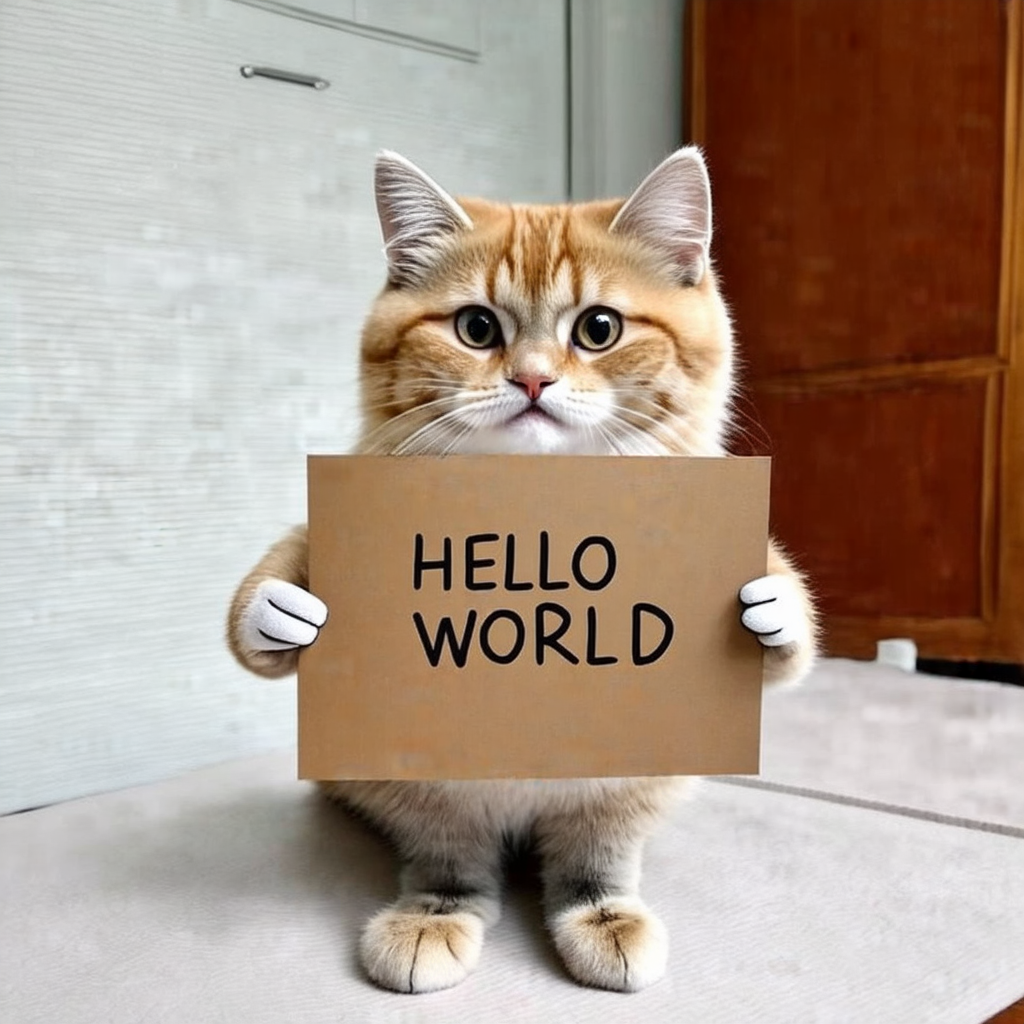

In [5]:
# Reset all distances
for layer in pipe.transformer.transformer_blocks:
    layer.attn.processor.query_dist = []
    layer.attn.processor.key_dist = []
    layer.attn.processor.value_dist = []
    layer.attn.processor.x_dist = []

    layer.attn.processor.query_img_dist = []
    layer.attn.processor.key_img_dist = []
    layer.attn.processor.value_img_dist = []
    layer.attn.processor.x_img_dist = []

    layer.attn.processor.query_text_dist = []
    layer.attn.processor.key_text_dist = []
    layer.attn.processor.value_text_dist = []
    layer.attn.processor.x_text_dist = []

    layer.attn.processor.query_sim = []
    layer.attn.processor.key_sim = []
    layer.attn.processor.value_sim = []
    layer.attn.processor.x_sim = []

generator = torch.Generator(device="cuda").manual_seed(0)
image = pipe(
    "A cat holding a sign that says hello world",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
    generator=generator
).images[0]
image

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

query_dist = []
key_dist = []
query_img_dist = []
key_img_dist = []
value_img_dist = []
x_img_dist = []
query_text_dist = []
key_text_dist = []
query_sim = []
key_sim = []
value_sim = []
x_sim = []
for layer in pipe.transformer.transformer_blocks:
    query_dist.append(layer.attn.processor.query_dist)
    key_dist.append(layer.attn.processor.key_dist)
    query_img_dist.append(layer.attn.processor.query_img_dist)
    key_img_dist.append(layer.attn.processor.key_img_dist)
    value_img_dist.append(layer.attn.processor.value_img_dist)
    x_img_dist.append(layer.attn.processor.x_img_dist)
    query_text_dist.append(layer.attn.processor.query_text_dist)
    key_text_dist.append(layer.attn.processor.key_text_dist)
    query_sim.append(layer.attn.processor.query_sim)
    key_sim.append(layer.attn.processor.key_sim)
    value_sim.append(layer.attn.processor.value_sim)
    x_sim.append(layer.attn.processor.x_sim)

query_dist = torch.tensor(query_dist)
key_dist = torch.tensor(key_dist)
query_img_dist = torch.tensor(query_img_dist)
key_img_dist = torch.tensor(key_img_dist)
value_img_dist = torch.tensor(value_img_dist)
x_img_dist = torch.tensor(x_img_dist)
query_text_dist = torch.tensor(query_text_dist)
key_text_dist = torch.tensor(key_text_dist)
query_sim = torch.tensor(query_sim)
key_sim = torch.tensor(key_sim)
value_sim = torch.tensor(value_sim)
x_sim = torch.tensor(x_sim)

/tmp/ipykernel_1004539/971429509.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  query_dist = torch.tensor(query_dist)


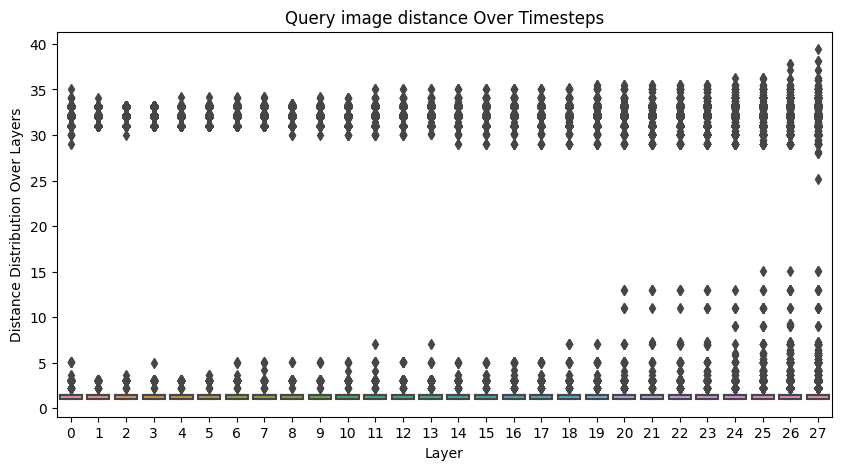

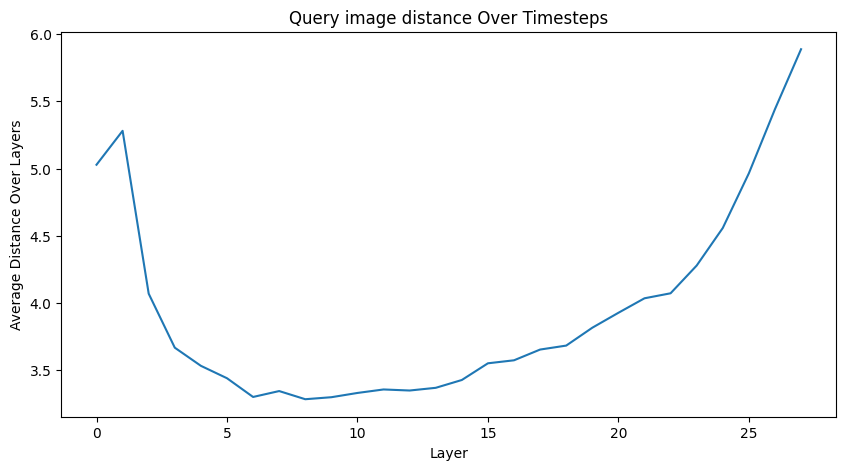

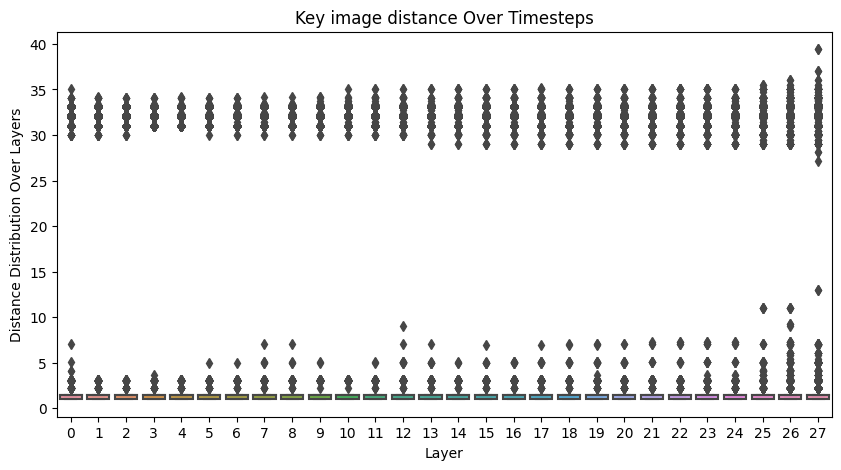

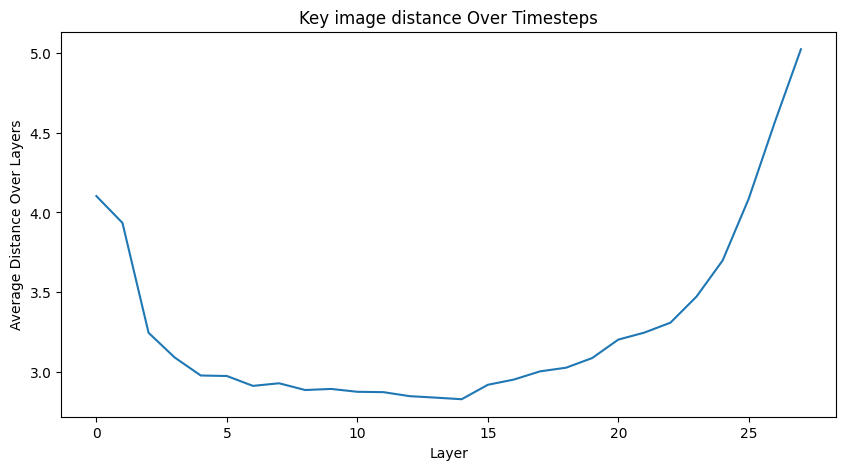

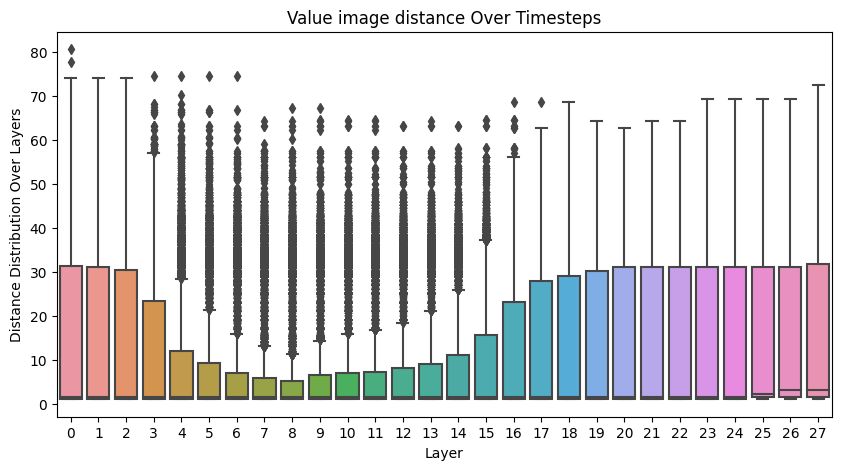

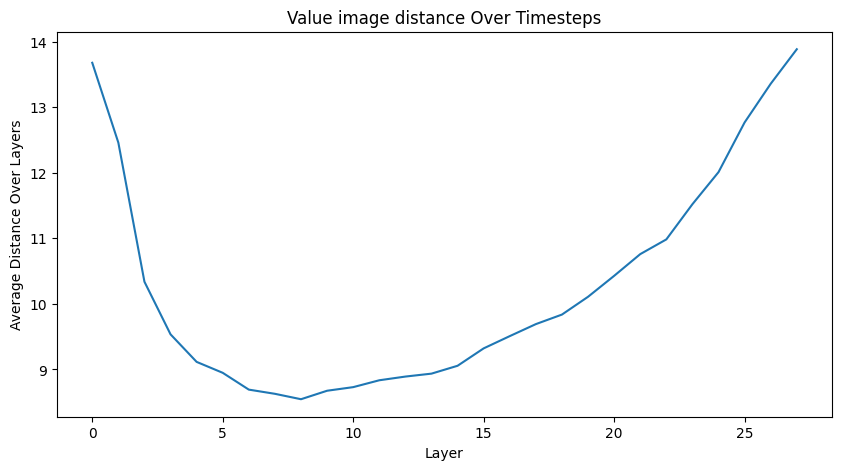

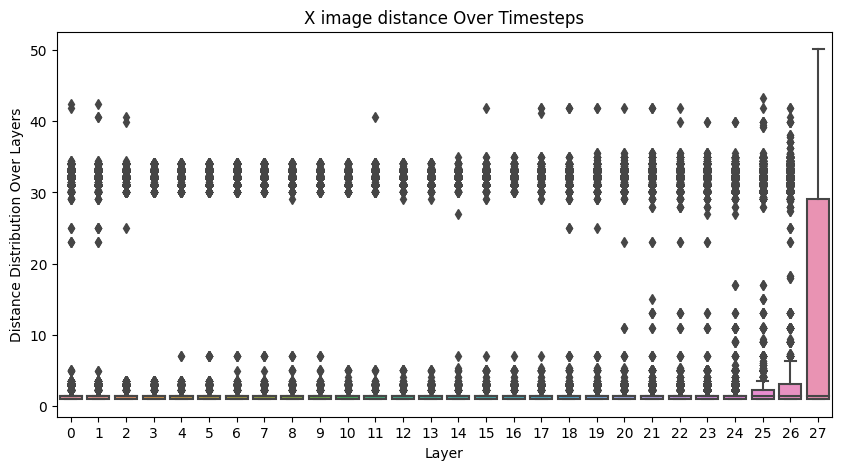

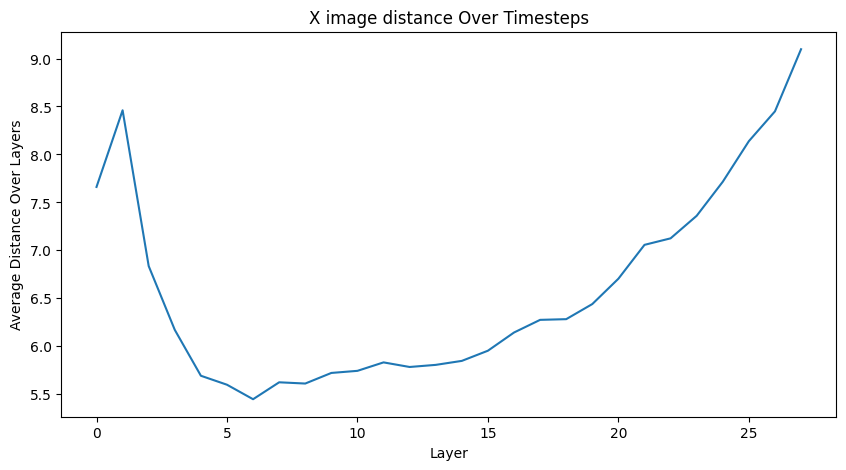

In [7]:
# Distribution of distances over time

# Flatten along the first dimension (layer)
query_dist_ = query_dist.transpose(0, 1).flatten(1, -1)
key_dist_ = key_dist.transpose(0, 1).flatten(1, -1)
query_img_dist_ = query_img_dist.transpose(0, 1).flatten(1, -1)
key_img_dist_ = key_img_dist.transpose(0, 1).flatten(1, -1)
value_img_dist_ = value_img_dist.transpose(0, 1).flatten(1, -1)
x_img_dist_ = x_img_dist.transpose(0, 1).flatten(1, -1)
query_text_dist_ = query_text_dist.transpose(0, 1).flatten(1, -1)
key_text_dist_ = key_text_dist.transpose(0, 1).flatten(1, -1)

# Plot over time
def plot_once(dist, title):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=dist.mT.cpu().numpy())
    plt.title(title + " Over Timesteps")
    plt.xlabel("Layer")
    plt.ylabel("Distance Distribution Over Layers")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(dist.mean(-1).cpu().numpy())
    plt.title(title + " Over Timesteps")
    plt.xlabel("Layer")
    plt.ylabel("Average Distance Over Layers")
    plt.show()

# plot_once(query_dist_, "Query distance")
# plot_once(key_dist_, "Key distance")
plot_once(query_img_dist_, "Query image distance")
plot_once(key_img_dist_, "Key image distance")
plot_once(value_img_dist_, "Value image distance")
plot_once(x_img_dist_, "X image distance")
# plot_once(query_text_dist_, "Query text distance")
# plot_once(key_text_dist_, "Key text distance")

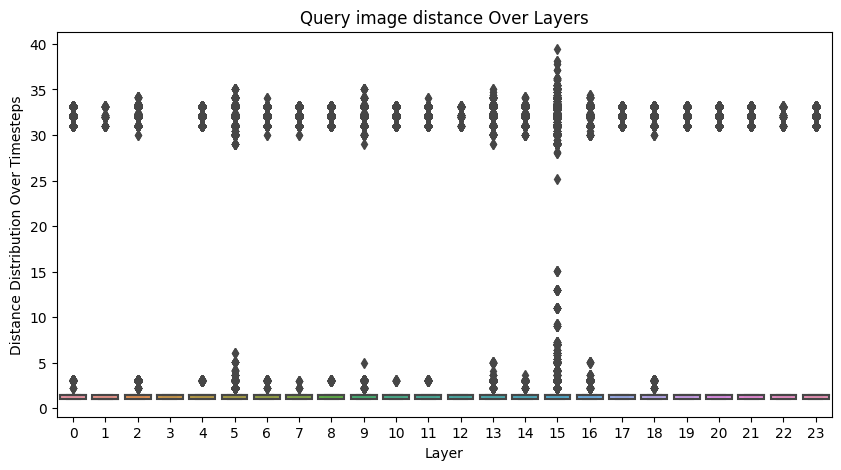

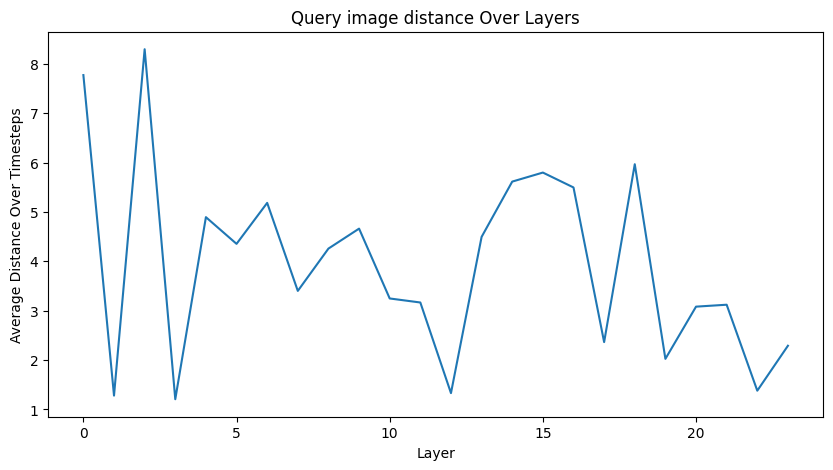

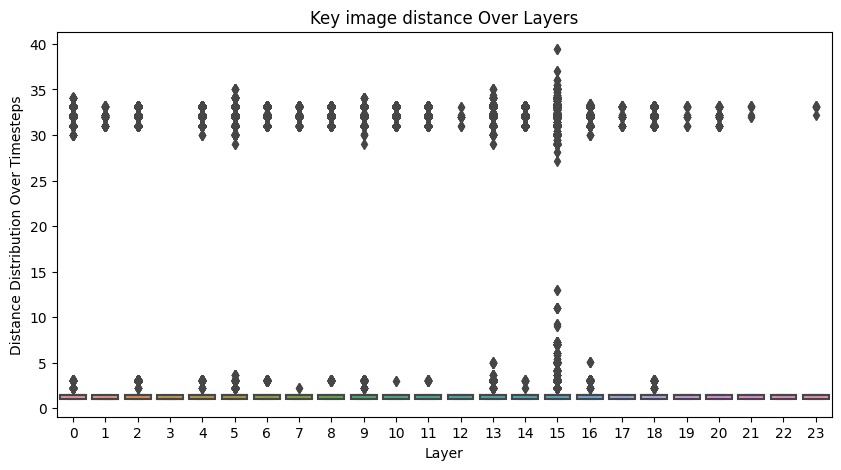

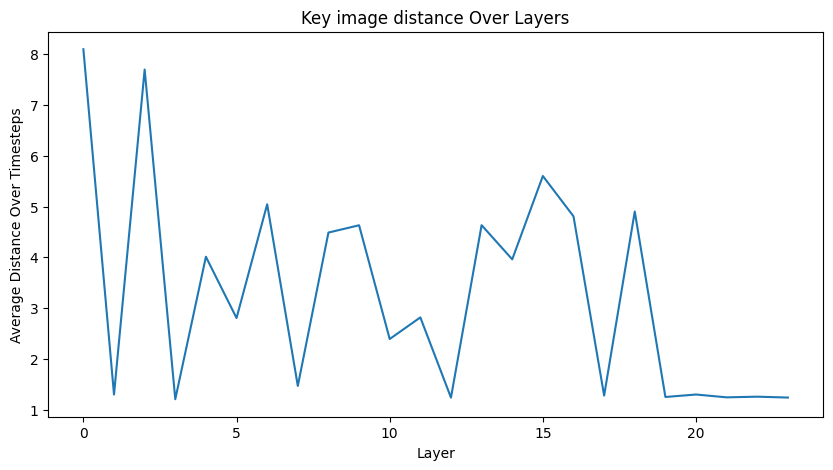

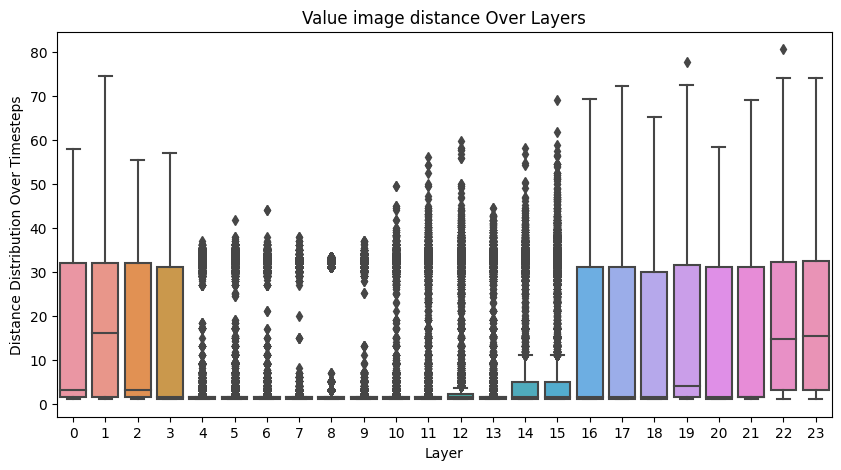

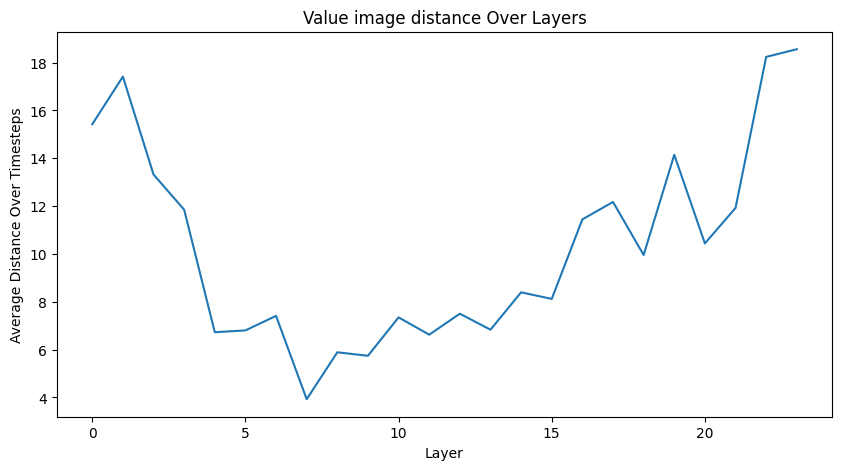

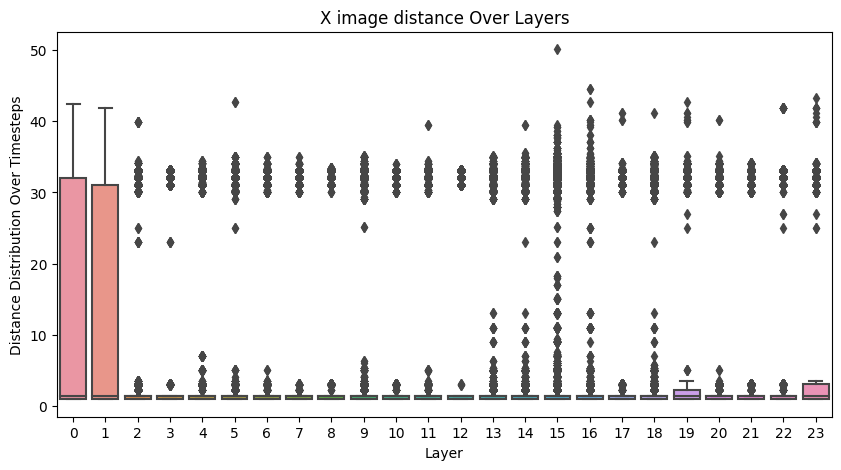

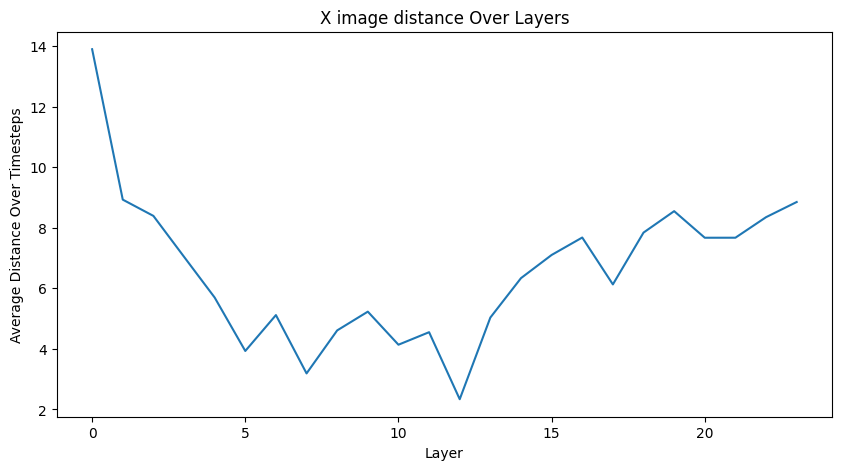

In [8]:
# Distribution of distances over time

# Flatten along the second dimension (layer)
query_dist_ = query_dist.flatten(1, -1)
key_dist_ = key_dist.flatten(1, -1)
query_img_dist_ = query_img_dist.flatten(1, -1)
key_img_dist_ = key_img_dist.flatten(1, -1)
value_img_dist_ = value_img_dist.flatten(1, -1)
x_img_dist_ = x_img_dist.flatten(1, -1)
query_text_dist_ = query_text_dist.flatten(1, -1)
key_text_dist_ = key_text_dist.flatten(1, -1)

# Plot over time
def plot_once(dist, title):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=dist.mT.cpu().numpy())
    plt.title(title + " Over Layers")
    plt.xlabel("Layer")
    plt.ylabel("Distance Distribution Over Timesteps")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(dist.mean(-1).cpu().numpy())
    plt.title(title + " Over Layers")
    plt.xlabel("Layer")
    plt.ylabel("Average Distance Over Timesteps")
    plt.show()

# plot_once(query_dist_, "Query distance")
# plot_once(key_dist_, "Key distance")
plot_once(query_img_dist_, "Query image distance")
plot_once(key_img_dist_, "Key image distance")
plot_once(value_img_dist_, "Value image distance")
plot_once(x_img_dist_, "X image distance")
# plot_once(query_text_dist_, "Query text distance")
# plot_once(key_text_dist_, "Key text distance")

In [9]:
# Conclusions:
# - The image distances appear to decay over time
# - The image distances seem to be tthe same over layers

# So we want a schedule over time, not over layers

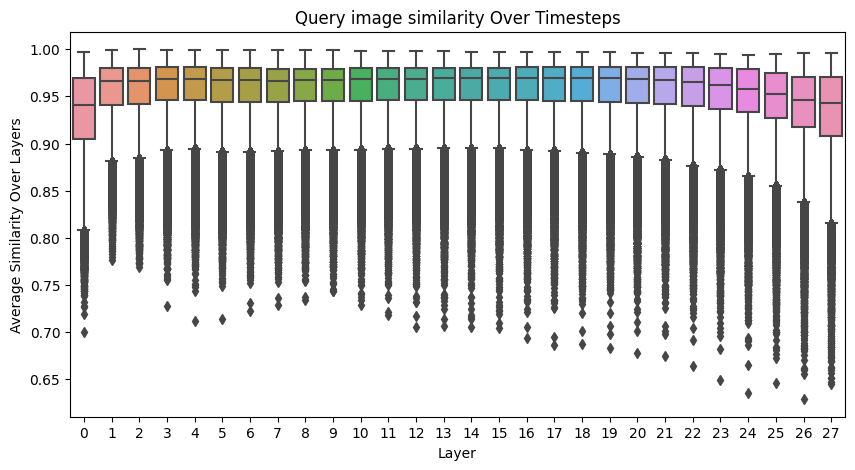

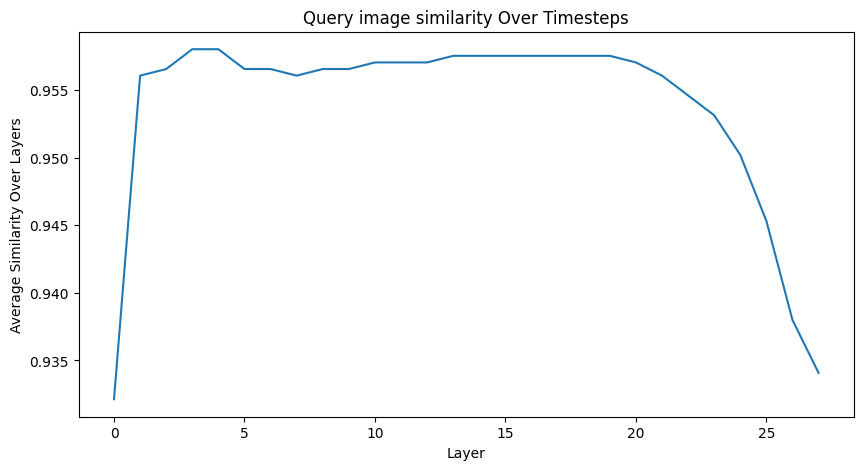

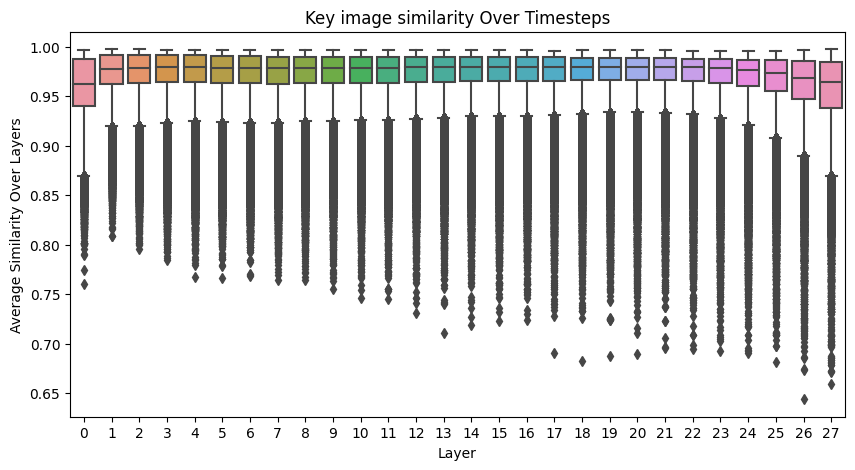

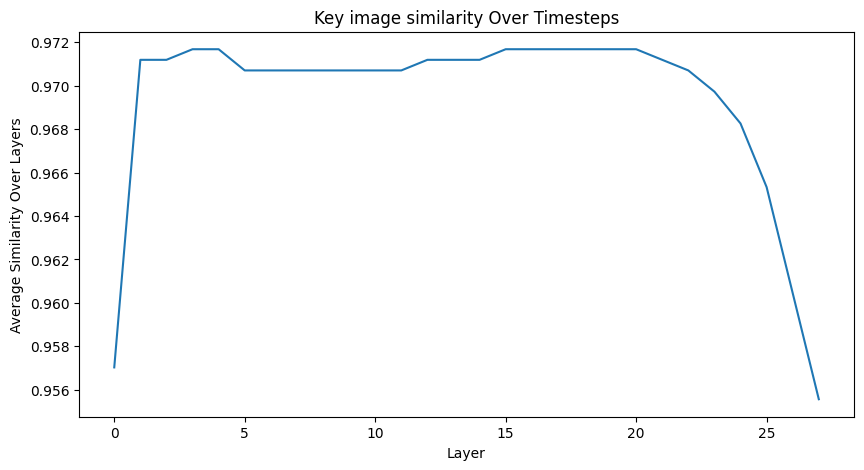

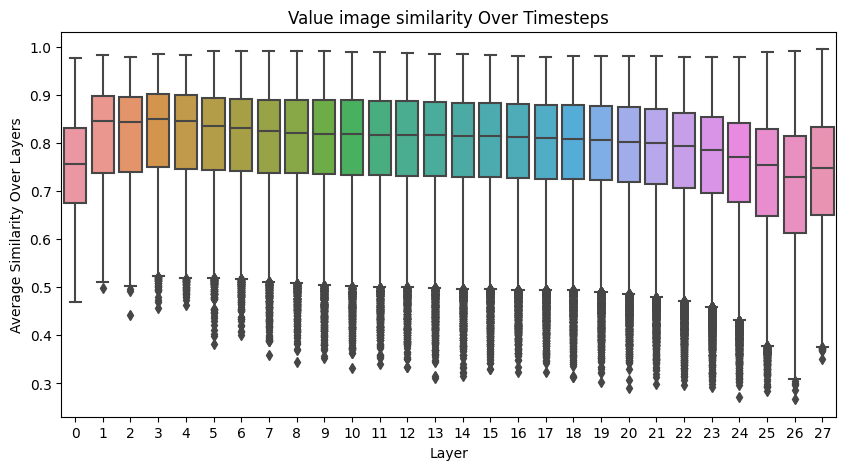

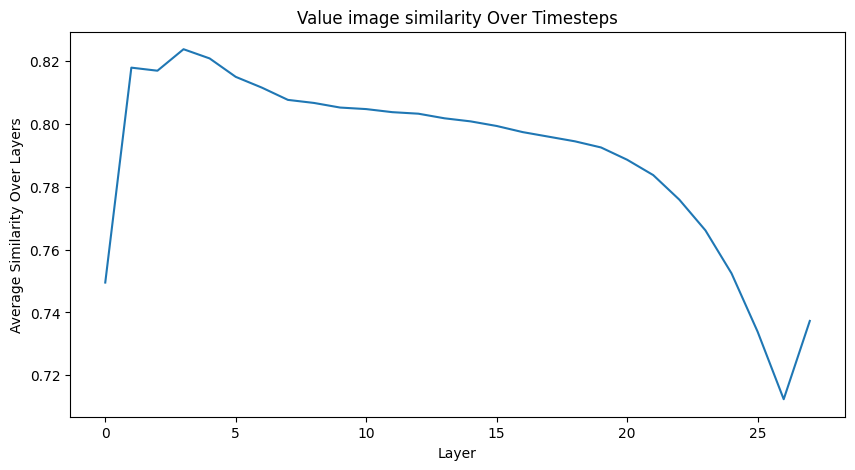

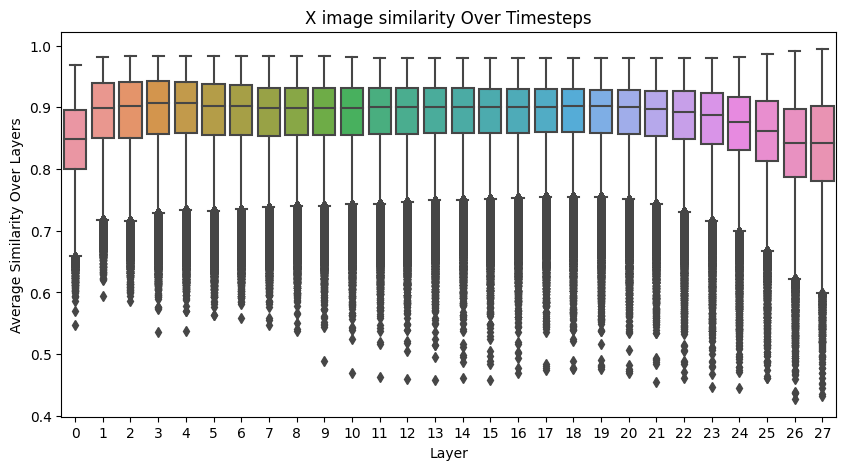

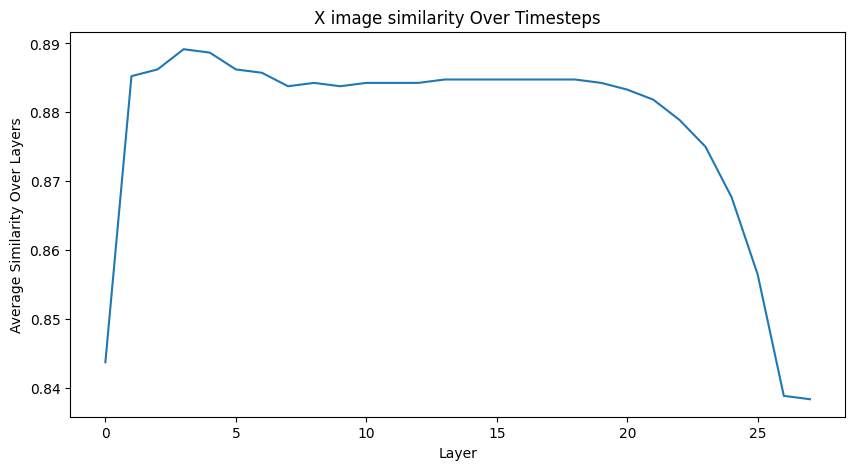

In [12]:
# Distribution of distances over time

# Flatten along the first dimension (layer)
query_img_dist_ = query_sim.transpose(0, 1).flatten(1, -1)
key_img_dist_ = key_sim.transpose(0, 1).flatten(1, -1)
value_img_dist_ = value_sim.transpose(0, 1).flatten(1, -1)
x_img_dist_ = x_sim.transpose(0, 1).flatten(1, -1)

# Plot over time
def plot_once(dist, title):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=dist.mT.cpu().numpy())
    plt.title(title + " Over Timesteps")
    plt.xlabel("Layer")
    plt.ylabel("Average Similarity Over Layers")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(dist.mean(-1).cpu().numpy())
    plt.title(title + " Over Timesteps")
    plt.xlabel("Layer")
    plt.ylabel("Average Similarity Over Layers")
    plt.show()

# plot_once(query_dist_, "Query distance")
# plot_once(key_dist_, "Key distance")
plot_once(query_img_dist_, "Query image similarity")
plot_once(key_img_dist_, "Key image similarity")
plot_once(value_img_dist_, "Value image similarity")
plot_once(x_img_dist_, "X image similarity")
# plot_once(query_text_dist_, "Query text distance")
# plot_once(key_text_dist_, "Key text distance")

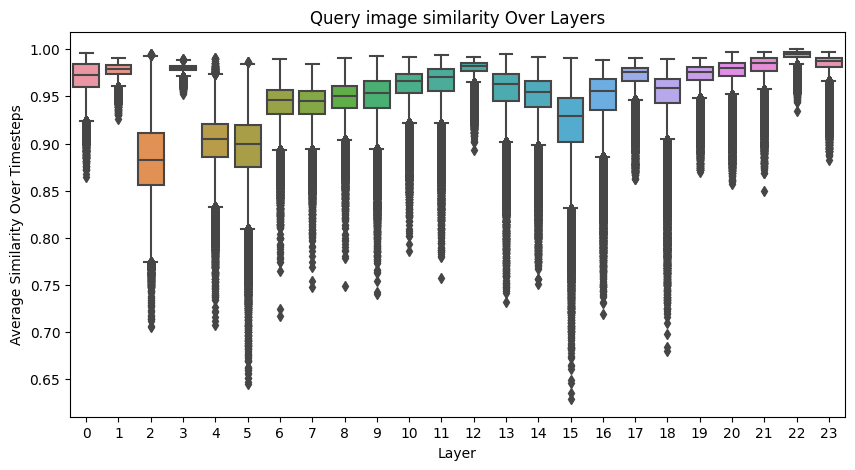

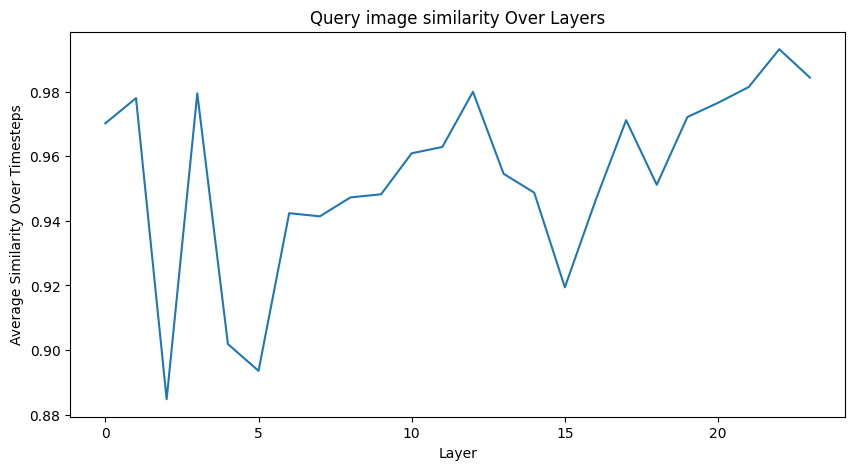

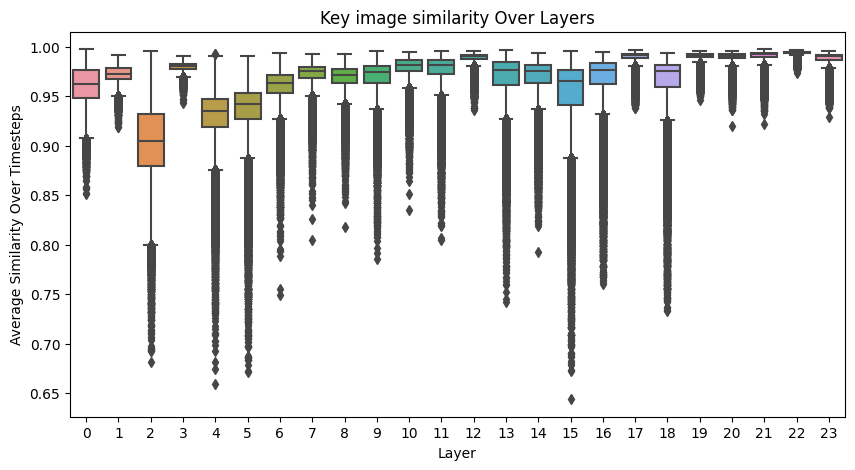

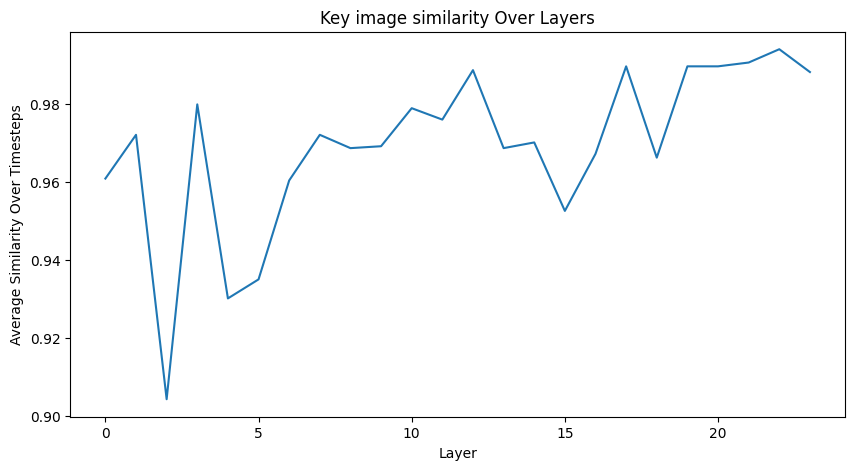

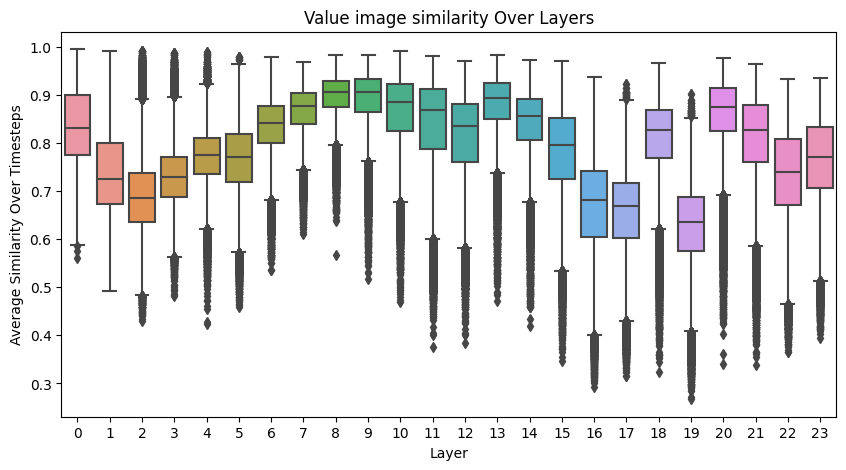

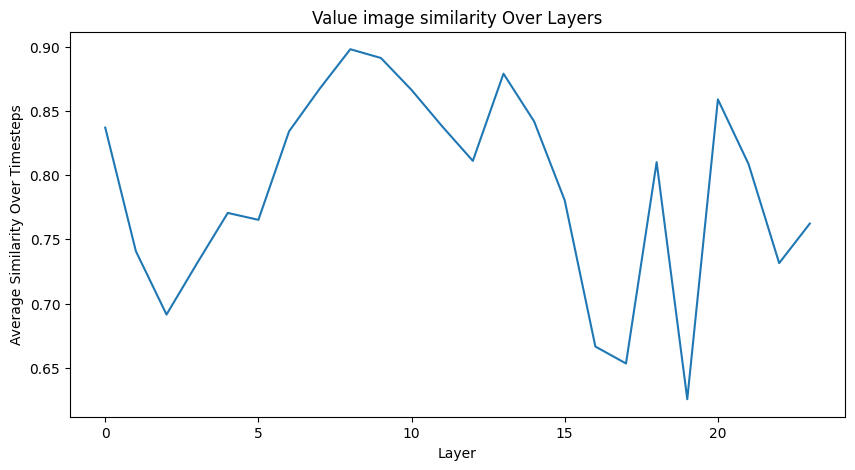

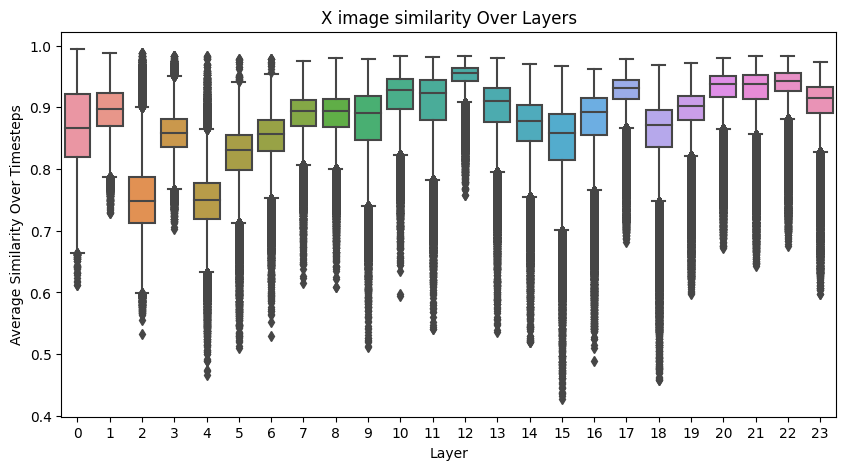

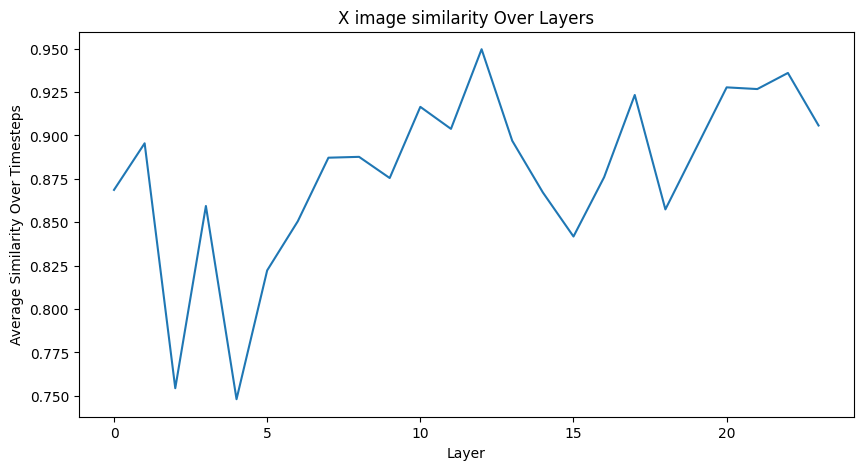

In [13]:
# Distribution of distances over time

# Flatten along the second dimension (layer)
query_img_dist_ = query_sim.flatten(1, -1)
key_img_dist_ = key_sim.flatten(1, -1)
value_img_dist_ = value_sim.flatten(1, -1)
x_img_dist_ = x_sim.flatten(1, -1)

# Plot over time
def plot_once(dist, title):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=dist.mT.cpu().numpy())
    plt.title(title + " Over Layers")
    plt.xlabel("Layer")
    plt.ylabel("Average Similarity Over Timesteps")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(dist.mean(-1).cpu().numpy())
    plt.title(title + " Over Layers")
    plt.xlabel("Layer")
    plt.ylabel("Average Similarity Over Timesteps")
    plt.show()

# plot_once(query_dist_, "Query distance")
# plot_once(key_dist_, "Key distance")
plot_once(query_img_dist_, "Query image similarity")
plot_once(key_img_dist_, "Key image similarity")
plot_once(value_img_dist_, "Value image similarity")
plot_once(x_img_dist_, "X image similarity")
# plot_once(query_text_dist_, "Query text distance")
# plot_once(key_text_dist_, "Key text distance")